<a href="https://colab.research.google.com/github/Oukey/M_L/blob/master/myHW_6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание 6. Классификация цветных изображений

Импорт нужных пакетов

In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

Обработка стандартного датасета **CIFAR10**(фотографии десяти классов: автомобиль, самолет, птица, кот, олень, собака, лягушка, лошадь, корабль и грузовик). 60000 цветных изображений (50000 обучающих и 10000 тестовых)  размером 32*32 пиксела (RGB) 

In [0]:
input_size = 3 * 32 * 32  # Количество цветов * размер изображения в точках
num_classes = 10          # Количество классов (10 видов изображений)
n_epochs = 5              # Количество эпох
batch_size = 10            # Размер мини-пакета входных данных
lr = 0.0001                # Скорость обучения 

Выполнение композиции трансформации с выполнением преобразования в тензоры с последующей нормализацией (преобразование цветных изображений в серую палитру).

In [59]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Обучающий датасет
cifar_trainset = dsets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Тестовый датасет
cifar_testset = dsets.CIFAR10(root='./data', train=False, download=True, transform=transform)

print('Размер обучающего датасета:', len(cifar_trainset))
print('Размер тестового датасета:', len(cifar_testset))

Files already downloaded and verified
Files already downloaded and verified
Размер обучающего датасета: 50000
Размер тестового датасета: 10000


Загрузка данных для обучения и тестирования

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=cifar_trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=cifar_testset, batch_size=batch_size, shuffle=True)

Инициализация девайса и стандартная фукция "шаг обучения"

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

Модель обучения

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class CifarModel(nn.Module):
    def __init__(self):
        super(CifarModel, self).__init__()
#         self.layer_1 = nn.Conv2d(3, 32, 5, 1, 2)
#         self.layer_2 = nn.Conv2d(32, 64, 4, 1, 2)
#         self.layer_3 = nn.Conv2d(64, 128, 3, 1, 2)
        self.layer_1 = nn.Sequential(
            nn.Conv2d(3, 32,  kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer_2 = nn.Sequential(
            nn.Conv2d(32, 64,  kernel_size=4, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer_3 = nn.Sequential(
            nn.Conv2d(64, 128,  kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
    
        self.pool = nn.MaxPool2d(2, 2)
        self.drop_out = nn.Dropout2d()
        self.fc_1 = nn.Linear(128*5*5, 100)
        self.fc_2 = nn.Linear(100, 20)
        self.fc_3 = nn.Linear(20, 10)

    def forward(self, x):
        '''Определение потоков данных'''
#         x = self.pool(F.relu(self.layer_1(x)))
#         x = self.pool(F.relu(self.layer_2(x)))    
#         x = self.pool(F.relu(self.layer_3(x)))
        
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = x.reshape(x.size(0), -1)
#         x = x.view(x.size(0), -1)
        
        x = self.drop_out(x)
#         x = F.relu(self.fc_1(x))
#         x = F.relu(self.fc_2(x))
#         x = F.relu(self.fc_3(x))    
        x = self.fc_1(x)
        x = self.fc_2(x)
        x = self.fc_3(x)
#         x = self.drop_out(x)
        return x
        

Обучение

In [63]:
from torch import optim, nn

model = CifarModel()
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
  
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        loss = train_step(images, labels)
        
# print(model.state_dict())    
print(loss)

0.474651962518692


Проверка точности

In [64]:

with torch.no_grad(): # проверяем на тестовой выборке
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Точность: {} %'.format(100 * correct / total))

Точность: 68.75 %


Визуализация результата

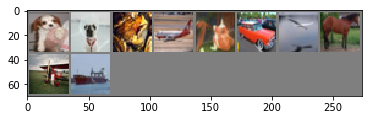

     собака/     собака/    лягушка/    самолёт/        кот/ автомобиль/      птица/     лошадь/    самолёт/    корабль


In [65]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('самолёт', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('/'.join('%11s' % classes[labels[j]] for j in range(10)))


Вычисление точности распознования по каждому из признаков

In [66]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Точность для %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Точность для самолёт : 62 %
Точность для автомобиль : 76 %
Точность для птица : 52 %
Точность для   кот : 37 %
Точность для олень : 64 %
Точность для собака : 69 %
Точность для лягушка : 80 %
Точность для лошадь : 67 %
Точность для корабль : 88 %
Точность для грузовик : 85 %
